In [1]:
import glob
import re
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from keras.models import Model
from keras.layers import Flatten, Dense, Input, GlobalAveragePooling2D, GlobalMaxPooling2D, Activation
from keras.layers import Convolution2D, MaxPooling2D
from keras import optimizers
from keras import backend as K
from keras.callbacks import EarlyStopping

SEED = 2017

Using TensorFlow backend.


In [2]:
# Data can be downloaded at http://vis-www.cs.umass.edu/lfw/#download

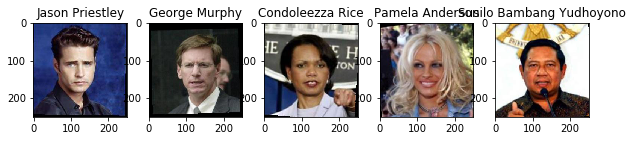

In [3]:
DATA_DIR = 'Data/lfw/'
images = glob.glob(DATA_DIR + '*/*.jpg')

plt.figure(figsize=(10, 10))

n_examples = 5
for i in range(5):
    rand = np.random.randint(len(images))
    image_name = re.search(DATA_DIR+'(.+?)\/', images[rand], re.IGNORECASE).group(1).replace('_', ' ')
    img = cv2.imread(images[rand])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(n_examples, n_examples, i+1)
    plt.title(image_name)
    plt.imshow(img)
    
plt.show()

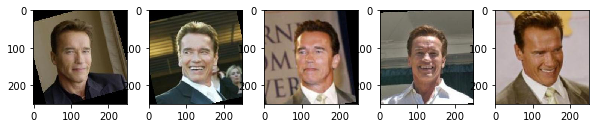

In [4]:
images_arnold = glob.glob(DATA_DIR + 'Arnold_Schwarzenegger/*.jpg')

plt.figure(figsize=(10, 10))

for i in range(n_examples):
    image_name = re.search(DATA_DIR+'(.+?)\/', images_arnold[i], re.IGNORECASE).group(1).replace('_', ' ')
    img = cv2.imread(images_arnold[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(n_examples, n_examples, i+1)
# plt.title(image_name)
    plt.imshow(img)
    
plt.show()

In [5]:
labels = np.asarray([re.search(DATA_DIR+'(.+?)\/', image, re.IGNORECASE).group(1) for image in np.asarray(images)])

In [6]:
print('Number of images: {}'.format(len(labels)))
print('Number of unique labels: {}'.format(len(np.unique(labels))))

Number of images: 13233
Number of unique labels: 5749


In [7]:
encoder = LabelBinarizer()
encoder.fit(labels)
y = encoder.transform(labels).astype(float)

In [8]:
X_train, X_val, y_train , y_val = train_test_split(images, y, test_size=0.2, random_state=SEED)

In [9]:
input_shape = (250, 250, 3)
img_input = Input(shape=input_shape)
inputs = img_input

# Block 1
x = Convolution2D(64, (3, 3), activation='relu', padding='same', name='conv1_1')(img_input)
x = Convolution2D(64, (3, 3), activation='relu', padding='same', name='conv1_2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(x)

# Block 2
x = Convolution2D(128, (3, 3), activation='relu', padding='same', name='conv2_1')(x)
x = Convolution2D(128, (3, 3), activation='relu', padding='same', name='conv2_2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(x)

# Block 3
x = Convolution2D(256, (3, 3), activation='relu', padding='same', name='conv3_1')(x)
x = Convolution2D(256, (3, 3), activation='relu', padding='same', name='conv3_2')(x)
x = Convolution2D(256, (3, 3), activation='relu', padding='same', name='conv3_3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(x)

# Block 4
x = Convolution2D(512, (3, 3), activation='relu', padding='same', name='conv4_1')(x)
x = Convolution2D(512, (3, 3), activation='relu', padding='same', name='conv4_2')(x)
x = Convolution2D(512, (3, 3), activation='relu', padding='same', name='conv4_3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(x)

# Block 5
x = Convolution2D(512, (3, 3), activation='relu', padding='same', name='conv5_1')(x)
x = Convolution2D(512, (3, 3), activation='relu', padding='same', name='conv5_2')(x)
x = Convolution2D(512, (3, 3), activation='relu', padding='same', name='conv5_3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='pool5')(x)

x = Flatten(name='flatten')(x)
x = Dense(4096, name='fc6')(x)
x = Activation('relu', name='fc6/relu')(x)
x = Dense(4096, name='fc7')(x)
x = Activation('relu', name='fc7/relu')(x)
x = Dense(len(y[0]), name='fc8')(x)
x = Activation('relu', name='fc8/softmax')(x)

model = Model(inputs, x)

opt = optimizers.Adam()
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [10]:
def random_shifts(image, shift_max_x=100, shift_max_y=100):
    width, height, _ = image.shape
    shift_x = np.random.randint(shift_max_x)
    shift_y = np.random.randint(shift_max_y)
    M = np.float32([[1, 0, shift_x],[0, 1, shift_y]])
    return (cv2.warpAffine(image, M, (height, width)))

def random_flip(image, p_flip=0.5):
    rand = np.random.random()
    if rand < p_flip:
        image = cv2.flip(image, 1)
    return image

def scale_image(image, scale_range=[0.6, 1.4]):
    width, height, _ = image.shape 
    
    scale_x = np.random.uniform(low=scale_range[0], high=scale_range[1])
    scale_y = np.random.uniform(low=scale_range[0], high=scale_range[1])
    scale_matrix = np.array([[scale_x, 0., (1. - scale_x) * width / 2.], 
                             [0., scale_y, (1. - scale_y) * height / 2.]], 
                            dtype=np.float32)
    return(cv2.warpAffine(image, scale_matrix, (width, height), flags=cv2.INTER_LINEAR, 
                         borderMode=cv2.BORDER_REFLECT_101))

In [11]:
img_rows = img_cols = 250
img_channels = 3

def batchgen(x, y, batch_size, transform=False):
    # Create empty numpy arrays
    images = np.zeros((batch_size, img_rows, img_cols, img_channels))
    class_id = np.zeros((batch_size, len(y[0])))

    while 1:
        for n in range(batch_size):
            i = np.random.randint(len(x))
            x_ = cv2.imread(x[i])
            x_ = cv2.cvtColor(x_, cv2.COLOR_BGR2RGB)
            if transform:
                x_ = random_shifts(x_, 10, 10)
                x_ = random_flip(x_)
                x_ = scale_image(x_, [0.8, 1,2])
            images[n] = x_
            class_id[n] = y[i]
        yield images, class_id

In [12]:
batch_size = 32
n_epochs = 1000
s_epoch = len(X_train) // batch_size
val_steps = len(X_val) // batch_size

In [13]:
callbacks = [EarlyStopping(monitor='val_acc', patience=5)]

In [ ]:
train_generator = batchgen(X_train, y_train, batch_size, True)
val_generator = batchgen(X_val, y_val, batch_size, False)

history = model.fit_generator(train_generator, 
                               steps_per_epoch=s_epoch, 
                               epochs=n_epochs, 
                               validation_data=val_generator,
                               validation_steps = val_steps,
                              callbacks=callbacks
                             )

Epoch 1/1000
330/330 [==============================] - 881s - loss: 15.0265 - acc: 0.0342 - val_loss: 14.8600 - val_acc: 0.0446
Epoch 2/1000
330/330 [==============================] - 868s - loss: 15.0487 - acc: 0.0402 - val_loss: 14.8502 - val_acc: 0.0507
Epoch 3/1000
301/330 [==========================>...] - ETA: 70s - loss: 15.0633 - acc: 0.0384

In [ ]:
test_generator = batchgen(X_val, y_val, batch_size, False)
preds = model.predict_generator(test_generator, steps=1)

y_val_ = [np.argmax(x) for x in y_val]
y_preds = [np.argmax(x) for x in preds]

accuracy_score(y_val_, y_preds)